In [434]:
import warnings
import torch
import matplotlib.pyplot as plt
from scipy.stats import norm
from torch_kmeans import KMeans

torch.set_printoptions(sci_mode=False)
warnings.filterwarnings("ignore", category=UserWarning)

In [435]:
# Constants
BELL_DISTANCE_FACTOR = 0.2

MU_SHIFT_COEFFICIENT = 30
MU_SPREAD_COEFFICIENT = 10

SIGMA_SHIFT_COEFFICIENT = 3
SIGMA_SPREAD_COEFFICIENT_START = 1.0
SIGMA_SPREAD_COEFFICIENT_END = 10.0

PALETTE = ["#9E0000", "#4F9E00", "#009E9E"]

In [436]:
def generate_data_gaussian(n_observations: int, parameters: torch.Tensor) -> torch.Tensor:
    mus = parameters[:, 0][:, None].squeeze(1)
    sigmas = parameters[:, 1][:, None].squeeze(1)

    distributions = torch.distributions.Normal(mus, sigmas)
    samples = distributions.sample(torch.Size([n_observations,])).t()

    return samples

In [437]:
def plot_observation(observation: torch.Tensor, show=True, color=PALETTE[0], title="", show_hist=True, fig=None, ax=None, y_adjustment=True) -> None:
    if fig is None or ax is None:
        fig, ax = plt.subplots()
    if show_hist:
        ax.hist(observation, density=True, bins=20, alpha=0.5, color=color)
    
    ax.scatter(observation, torch.zeros(observation.size()), s=8, alpha=0.5, color=color)

    if title != "":
        ax.set_title(title)
    if y_adjustment:
        y_min, y_max = ax.get_ylim()
        ax.set_ylim(y_min - 0.01, y_max)
    if show:
        plt.show()

In [457]:
def plot_gaussian_distribution_and_observations(distribution_parameters: torch.Tensor, observations : torch.Tensor, title: str = "", extra_legend: str = "") -> None:
    fig, ax = plt.subplots()
    if observations.dim() > 1:
        for index, sample in enumerate(observations):
            plot_observation(sample, color=PALETTE[index % len(PALETTE)], show=False, show_hist=False, fig=fig,
                             ax=ax, y_adjustment=False)
    else:
        plot_observation(observations, show=False, show_hist=False, fig=fig, ax=ax,
                         y_adjustment=False)
    
    for index, parameters in enumerate(distribution_parameters):
        mu = parameters[0]
        sigma = parameters[1]
        min_value = torch.min(observations)
        max_value = torch.max(observations)
        dist = (max_value - min_value) * BELL_DISTANCE_FACTOR

        x_axis = torch.arange(min_value - dist, max_value + dist)
        ax.plot(x_axis.numpy(), norm.pdf(x_axis.numpy(), mu.numpy(), sigma.numpy()) + 0.005,
                 label=r'$\mu_' + str(index + 1) + r'=' + str(round(mu.item(), 2)) +
                       r',\ \sigma_' + str(index + 1) + '=' + str(round(sigma.item(), 2)) + r'$', color=PALETTE[index % len(PALETTE)])
    
    if title != "":
        ax.set_title(title)
    
    plt.legend()
    plt.show()

In [439]:
def init_original_parameters(k_parameters: int = 2) -> torch.Tensor:
    # Creates a set of mus that starts on MU_SHIFT_COEFFICIENT and ends on MU_SHIFT_COEFFICIENT * k_parameters
    # with step MU_SHIFT_COEFFICIENT. A random number between 0 and MU_SPREAD_COEFFICIENT is added to each
    # value in the range
    mu_range = torch.range(MU_SHIFT_COEFFICIENT, MU_SHIFT_COEFFICIENT * k_parameters, MU_SHIFT_COEFFICIENT)
    mus = torch.rand(k_parameters) * MU_SPREAD_COEFFICIENT + mu_range

    # Creates a set of sigmas between SIGMA_SHIFT_COEFFICIENT and SIGMA_SPREAD_COEFFICIENT_END
    sigma_spread = torch.rand(1) * (SIGMA_SPREAD_COEFFICIENT_END - SIGMA_SPREAD_COEFFICIENT_START) + SIGMA_SPREAD_COEFFICIENT_START
    sigmas = torch.rand(k_parameters) * sigma_spread + SIGMA_SHIFT_COEFFICIENT
    
    return torch.stack((mus, sigmas), dim=1)

In [440]:
def init_random_parameters(k_parameters: int = 2) -> torch.Tensor:
    # Creates a range of mus between MU_SHIFT_COEFFICIENT and MU_SHIFT_COEFFICIENT * k_parameters
    mus = torch.rand(k_parameters) * (MU_SHIFT_COEFFICIENT * k_parameters - MU_SHIFT_COEFFICIENT) + MU_SHIFT_COEFFICIENT
    # Creates a range of sigmas between SIGMA_SPREAD_COEFFICIENT_START and SIGMA_SPREAD_COEFFICIENT_END
    sigmas = torch.rand(k_parameters) * (SIGMA_SPREAD_COEFFICIENT_END - SIGMA_SPREAD_COEFFICIENT_START) + SIGMA_SPREAD_COEFFICIENT_START

    return torch.stack((mus, sigmas), dim=1)

In [441]:
def calculate_likelihood_gaussian_observation(x_n : torch.Tensor, mu_k: torch.Tensor, sigma_k: torch.Tensor) -> torch.Tensor:
    def log_gaussian_function(x: torch.Tensor, mu: torch.Tensor, sigma: torch.Tensor) -> torch.Tensor:
        return (-1/2) * torch.log(2 * torch.pi * sigma**2) - ((x-mu)**2/(2 * sigma**2))
    return log_gaussian_function(x_n, mu_k, sigma_k)

In [442]:
def calculate_membership_dataset(observations: torch.Tensor, parameters: torch.Tensor) -> torch.Tensor:
    mus = parameters[:, 0].unsqueeze(0)
    sigmas = parameters[:, 1].unsqueeze(0)
    observations_expanded = observations.unsqueeze(-1)

    log_likelihoods = calculate_likelihood_gaussian_observation(observations_expanded, mus, sigmas)
    max_values, _ = torch.max(log_likelihoods, dim=-1, keepdim=True)
    one_hot_membership_matrix = (log_likelihoods == max_values).to(torch.float)
    
    return one_hot_membership_matrix

In [443]:
def recalculate_parameters(x_dataset: torch.Tensor, membership_data: torch.Tensor) -> torch.Tensor:
    values_per_membership = torch.transpose(membership_data, 0, 1) * x_dataset
    new_parameters = []
    for t_membership in values_per_membership:
        non_zero_mask = t_membership != 0
        t_membership = t_membership[non_zero_mask]
        new_mu = torch.mean(t_membership)
        new_std = torch.std(t_membership)
        if new_mu.item() != new_mu.item() or new_std.item() != new_std.item():  # if nan
            params = init_random_parameters(1)
            new_mu = params[0][0]
            new_std = params[0][1]
        new_parameters.append([new_mu, new_std])
    return torch.Tensor(new_parameters)

In [450]:
def expectation_maximization(observations: int = 200, k_parameters: int = 2, iterations: int = 5) -> None:
    original_parameters = init_original_parameters(k_parameters)
    samples = generate_data_gaussian(observations, original_parameters)
    parameters = init_random_parameters(k_parameters)

    plot_gaussian_distribution_and_observations(parameters, samples, title="Iteration #0", extra_legend="test")
    
    for iteration in range(1, iterations + 1):
        membership_data = calculate_membership_dataset(torch.flatten(samples), parameters)
        parameters = recalculate_parameters(torch.flatten(samples), membership_data)
        plot_gaussian_distribution_and_observations(parameters, samples, title=f'Iteration #{iteration}')

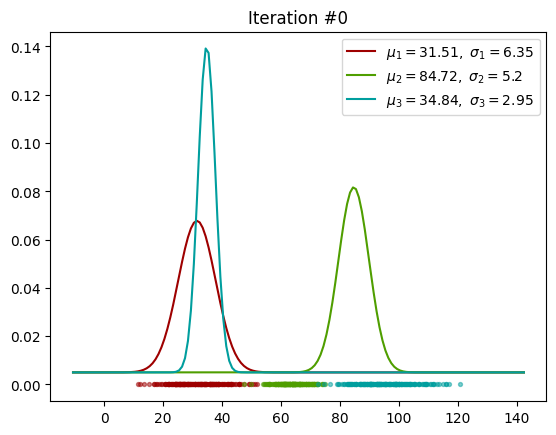

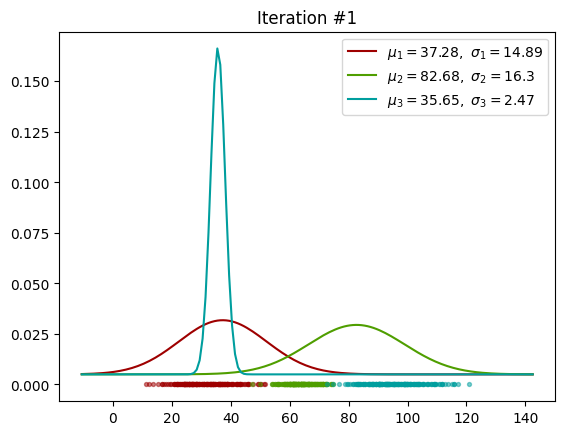

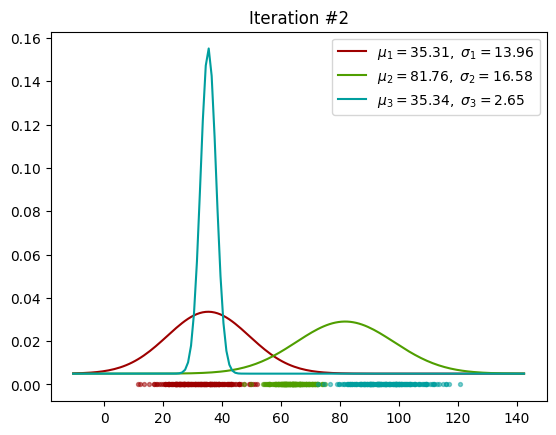

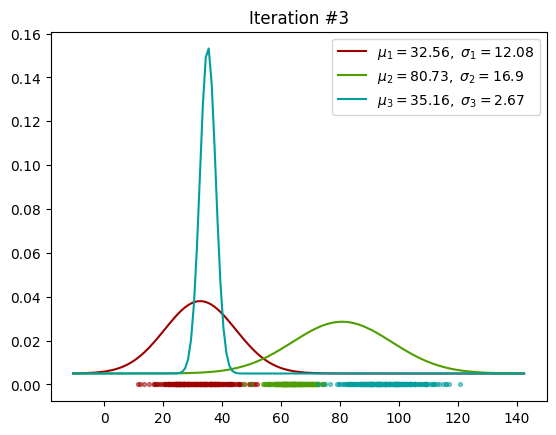

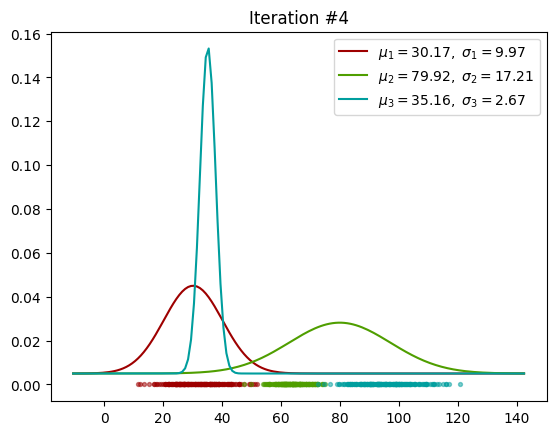

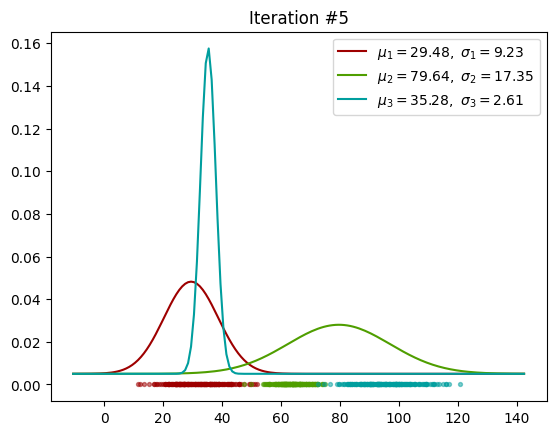

In [459]:
expectation_maximization(k_parameters=3)